In [82]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [83]:
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'INTC', 'AMD']

### Download 2 Years of Stock Data

In [84]:
# Download 2 years of stock data
data = {}

for ticker in tickers:
    df = yf.download(ticker, period="2y")
    df.dropna(inplace=True)
    data[ticker] = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    print(f"Downloaded {ticker} data: {len(df)} days")

[*********************100%***********************]  1 of 1 completed


Downloaded AAPL data: 501 days


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded GOOGL data: 501 days
Downloaded MSFT data: 501 days


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded AMZN data: 501 days
Downloaded META data: 501 days


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded TSLA data: 501 days
Downloaded NFLX data: 501 days


[*********************100%***********************]  1 of 1 completed


Downloaded NVDA data: 501 days


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Downloaded INTC data: 501 days
Downloaded AMD data: 501 days


Save Data to .csv

In [85]:
# Save the data in df to CSV
for ticker, df in data.items():
    df.to_csv(f'Stocks/{ticker}_data.csv')

Load Data from .csv

In [86]:
# Load the data from CSV
data = {}
for ticker in tickers:
    df = pd.read_csv(f'Stocks/{ticker}_data.csv', index_col=0, parse_dates=True)
    # Convert columns to numeric, coercing errors to NaN, and drop rows with NaN values
    df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].apply(pd.to_numeric, errors='coerce')
    df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
    data[ticker] = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype({'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close': 'float64', 'Volume': 'int64'})

/tmp/ipykernel_67575/4098107145.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f'Stocks/{ticker}_data.csv', index_col=0, parse_dates=True)
/tmp/ipykernel_67575/4098107145.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f'Stocks/{ticker}_data.csv', index_col=0, parse_dates=True)
/tmp/ipykernel_67575/4098107145.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f'Stocks/{ticker}_data.csv', index_col=0, parse_dates=True)
/tmp/ipykernel_67575/4098107145.py:4: UserWarning: Could not infer format, so each element will b

### Feature Engineering

In [87]:
def add_technical_indicators(df):
    # Copy the dataframe to avoid modifying the original
    df_new = df.copy()
    
    # Moving averages
    df_new['MA5'] = df_new['Close'].rolling(window=5).mean()
    df_new['MA20'] = df_new['Close'].rolling(window=20).mean()
    df_new['MA50'] = df_new['Close'].rolling(window=50).mean()
    
    # Price momentum
    df_new['Price_Change'] = df_new['Close'].pct_change()
    df_new['Price_Change_5d'] = df_new['Close'].pct_change(periods=5)
    
    # Volatility
    df_new['Volatility_5d'] = df_new['Close'].pct_change().rolling(window=5).std()
    
    # Volume indicators
    df_new['Volume_Change'] = df_new['Volume'].pct_change()
    df_new['Volume_MA5'] = df_new['Volume'].rolling(window=5).mean()
    
    # Relative strength index (simplified)
    delta = df_new['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df_new['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    exp1 = df_new['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df_new['Close'].ewm(span=26, adjust=False).mean()
    df_new['MACD'] = exp1 - exp2
    df_new['MACD_Signal'] = df_new['MACD'].ewm(span=9, adjust=False).mean()
    
    # Drop NaN values
    df_new.dropna(inplace=True)
    
    return df_new

# Apply technical indicators to all stocks
for ticker in tickers:
    data[ticker] = add_technical_indicators(data[ticker])

In [88]:
#list key of data
print(data['AAPL'].keys())

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'MA20', 'MA50',
       'Price_Change', 'Price_Change_5d', 'Volatility_5d', 'Volume_Change',
       'Volume_MA5', 'RSI', 'MACD', 'MACD_Signal'],
      dtype='object')


### Prepare the Dataset for Regression

In [89]:
# Define prediction horizon
PREDICT_DAYS = 30

X_data = {}
y_data = {}

for ticker, df in data.items():
    # Create the target variable: price growth over next PREDICT_DAYS days
    df['Target_Growth'] = df['Close'].pct_change(periods=PREDICT_DAYS).shift(-PREDICT_DAYS)
    
    # Drop rows with NaN targets (last PREDICT_DAYS rows)
    df = df.dropna()
    
    # Select features
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 
                'MA5', 'MA20', 'MA50', 'Price_Change', 'Price_Change_5d',
                'Volatility_5d', 'Volume_Change', 'Volume_MA5', 'RSI', 
                'MACD', 'MACD_Signal']
    
    X_data[ticker] = df[features]
    y_data[ticker] = df['Target_Growth']
    
    print(f"{ticker}: {len(df)} samples after preparation")

AAPL: 422 samples after preparation
GOOGL: 422 samples after preparation
MSFT: 422 samples after preparation
AMZN: 422 samples after preparation
META: 422 samples after preparation
TSLA: 422 samples after preparation
NFLX: 422 samples after preparation
NVDA: 422 samples after preparation
INTC: 422 samples after preparation
AMD: 422 samples after preparation


### Build Combined Dataset from All Stocks

In [90]:
# Combine all stock data for a unified model
X_combined = pd.DataFrame()
y_combined = pd.Series()

for ticker in tickers:
    # Add a ticker identifier column
    X_local = X_data[ticker].copy()
    X_local['Ticker'] = ticker
    
    # One-hot encode the ticker
    X_local = pd.get_dummies(X_local, columns=['Ticker'], prefix='Stock')
    
    # Append to combined dataset
    X_combined = pd.concat([X_combined, X_local])
    y_combined = pd.concat([y_combined, y_data[ticker]])

# Reset index
X_combined.reset_index(drop=True, inplace=True)
y_combined.reset_index(drop=True, inplace=True)

print(f"Combined dataset shape: {X_combined.shape}")
print(f"Combined target shape: {y_combined.shape}")

Combined dataset shape: (4220, 26)
Combined target shape: (4220,)


/tmp/ipykernel_67575/628331997.py:15: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_combined = pd.concat([y_combined, y_data[ticker]])


### Split the Dataset

In [91]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42
)

### Scale Features

In [92]:
# Identify numeric columns (exclude the one-hot encoded columns)
numeric_cols = [col for col in X_combined.columns if not col.startswith('Stock_')]

# Scale numeric features
scaler = MinMaxScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (3376, 26), Test set: (844, 26)


### Train Random Forest Regression Model


In [93]:
# Create and train a Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print("Random Forest model trained successfully")

Random Forest model trained successfully


### Evaluate Models

In [94]:
# Function to evaluate regression models
def evaluate_model(model, X, y, model_name="Model"):
    # Make predictions
    y_pred = model.predict(X)
    
    # Calculate metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R² Score: {r2:.6f}")
    
    return y_pred

# Evaluate Random Forest model
rf_preds = evaluate_model(rf_model, X_test, y_test, "Random Forest")

Random Forest Performance:
MSE: 0.007816
RMSE: 0.088409
MAE: 0.057144
R² Score: 0.611927


### Feature Importance Analysis

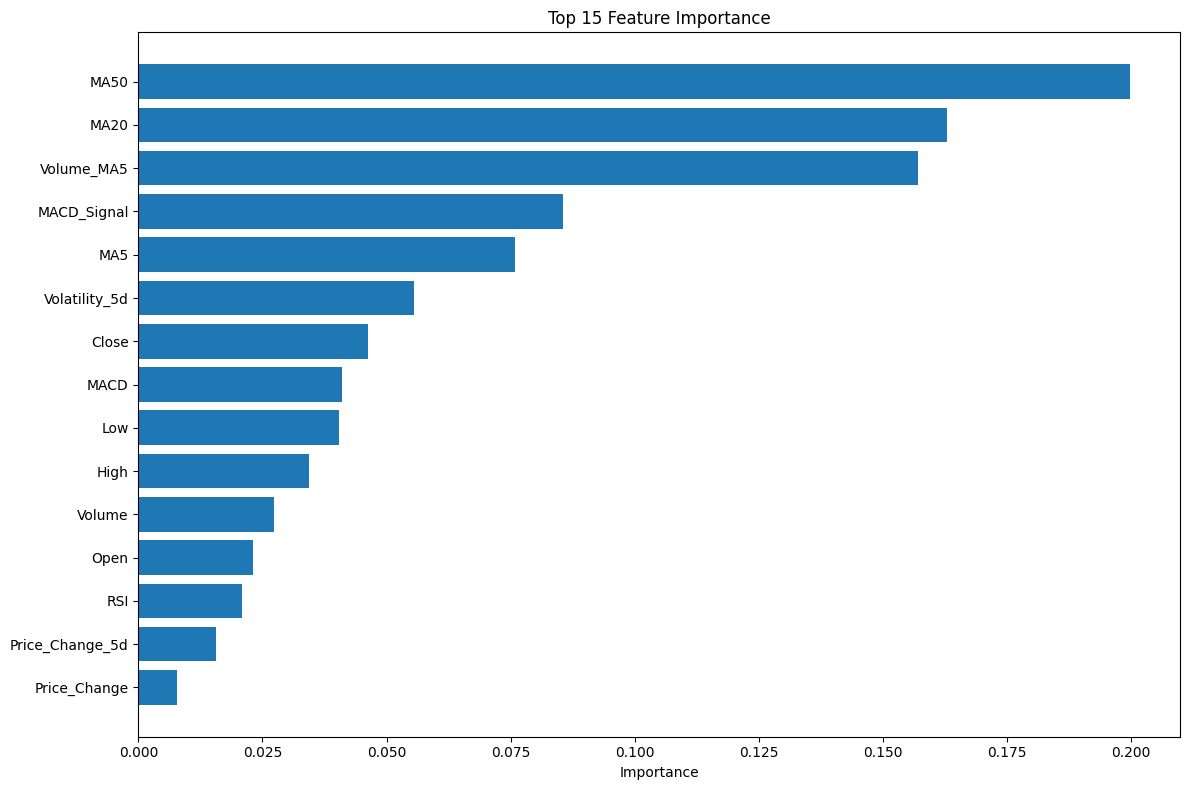

In [95]:
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()  # Display the most important feature at the top
plt.tight_layout()
plt.show()

### Prepare Latest Data for Prediction

In [96]:
# Function to prepare the latest data for prediction
def prepare_latest_data():
    latest_data = {}
    
    for ticker in tickers:
        # Get the original dataframe
        df = data[ticker]
        
        # Use the last row as our latest data point
        latest = df.iloc[-1:].copy()
        
        # One-hot encode the ticker
        latest_encoded = pd.DataFrame()
        for t in tickers:
            col_name = f'Stock_{t}'
            latest_encoded[col_name] = [1 if t == ticker else 0]
        
        # Combine with the features
        features = ['Open', 'High', 'Low', 'Close', 'Volume', 
                   'MA5', 'MA20', 'MA50', 'Price_Change', 'Price_Change_5d',
                   'Volatility_5d', 'Volume_Change', 'Volume_MA5', 'RSI', 
                   'MACD', 'MACD_Signal']
        
        for feature in features:
            latest_encoded[feature] = latest[feature].values
        
        # Scale the numeric features
        latest_encoded[numeric_cols] = scaler.transform(latest_encoded[numeric_cols])
        
        latest_data[ticker] = latest_encoded
        
    return latest_data

latest_data = prepare_latest_data()

### Predict Growth for Each Stock

In [97]:
# Make predictions using both models
predictions = {}

for ticker in tickers:
    # Align feature columns with X_train
    latest_data_aligned = latest_data[ticker].reindex(columns=X_train.columns, fill_value=0)
    
    rf_prediction = rf_model.predict(latest_data_aligned)[0]
    
    predictions[ticker] = rf_prediction

# Sort predictions
sorted_predictions = {k: v for k, v in sorted(predictions.items(), key=lambda item: item[1], reverse=True)}

# Print results
print("Predicted 30-day growth per stock:")
for ticker, growth in sorted_predictions.items():
    print(f"{ticker}: {(growth * 100):.2f}%")

# Identify the best stock
best_stock = max(predictions, key=predictions.get)
print(f"\n📈 Best stock to pick: {best_stock}")

Predicted 30-day growth per stock:
AMD: 4.50%
GOOGL: 3.69%
MSFT: 3.61%
META: 3.21%
NVDA: 2.88%
INTC: 0.32%
AAPL: -0.37%
AMZN: -2.49%
NFLX: -6.76%
TSLA: -7.65%

📈 Best stock to pick: AMD


### Visualize Predictions

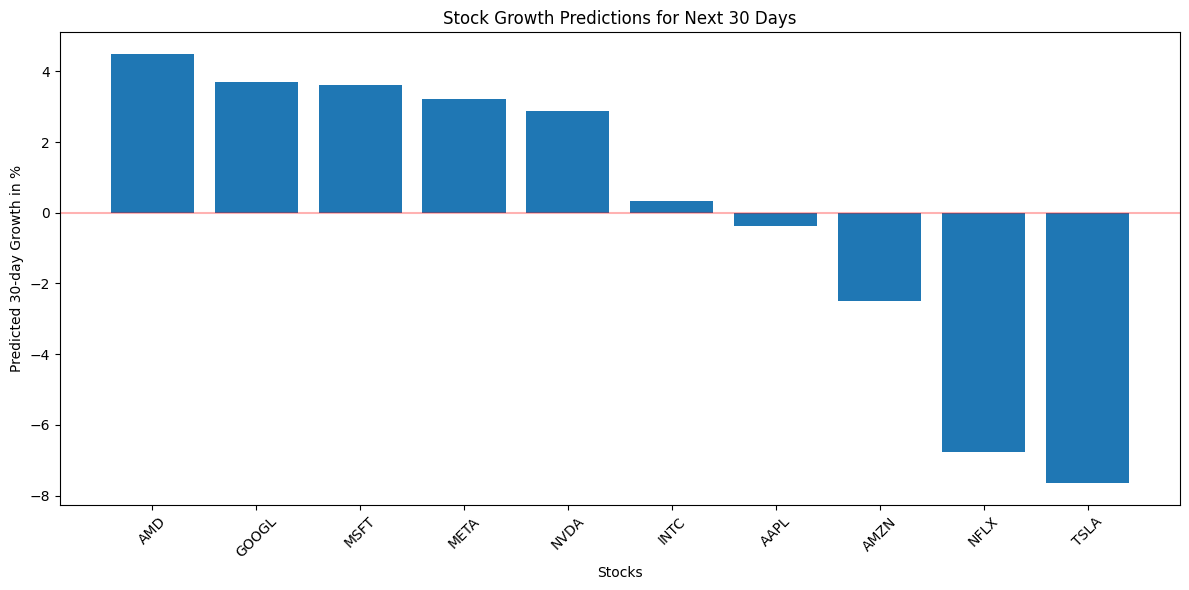

In [98]:
# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.bar(sorted_predictions.keys(), [v * 100 for v in sorted_predictions.values()])
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xlabel('Stocks')
plt.ylabel('Predicted 30-day Growth in %')
plt.title('Stock Growth Predictions for Next 30 Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Cross-Validation Analysis

In [99]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross validation
cv_scores = cross_val_score(rf_model, X_combined, y_combined, cv=5, scoring='neg_mean_squared_error')

# Convert to positive RMSE
cv_rmse = np.sqrt(-cv_scores)

print("Cross-Validation Results (RMSE):")
print(f"Mean RMSE: {cv_rmse.mean():.6f}")
print(f"Standard Deviation: {cv_rmse.std():.6f}")

Cross-Validation Results (RMSE):
Mean RMSE: 0.169181
Standard Deviation: 0.045400
